In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

rng = np.random.default_rng(42)

In [2]:
# Hiperparametry
ILE_DANYCH = 1000  
ILE_EPOK   = 800
PRZEDZIAL  = (0.0, 12)
SZUM_SIGMA = 0.1
HIDDEN_NEURONS = 256
BATCH_SIZE     = 128
LR_START       = 0.002

In [3]:
# Funkcja, szum, podział, skalowanie
def f(x):
    return 0.5 * np.cos(0.2 * x**2) + 0.5

x_dense = np.arange(PRZEDZIAL[0], PRZEDZIAL[1] + 0.05, 0.05)
y_dense = f(x_dense)

x_data = rng.uniform(PRZEDZIAL[0], PRZEDZIAL[1], size=(ILE_DANYCH, 1))
y_data = f(x_data) + rng.normal(0, SZUM_SIGMA, size=(ILE_DANYCH, 1))

X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    x_data, y_data, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=1/3, random_state=42
)   

sx = StandardScaler().fit(X_tr)
sy = StandardScaler().fit(y_tr)

X_tr_s = sx.transform(X_tr)
X_val_s = sx.transform(X_val)
y_tr_s = sy.transform(y_tr)
y_val_s = sy.transform(y_val)

In [4]:
# Definicja modelu
model = Sequential([
    Dense(HIDDEN_NEURONS, activation='tanh', input_shape=(1,)),
    Dense(HIDDEN_NEURONS, activation='tanh'),
    Dense(HIDDEN_NEURONS, activation='tanh'),
    Dense(HIDDEN_NEURONS, activation='tanh'),
    Dense(1, activation='linear')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR_START),
    loss='mse'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=120,         
    restore_best_weights=True,
    verbose=1
)

lr_sched = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,            
    patience=30,           
    min_lr=1e-5,
    verbose=1
)

C:\Users\wesol\anaconda3\envs\DataScience\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Trening
history = model.fit(
    X_tr_s, y_tr_s,
    validation_data=(X_val_s, y_val_s),
    epochs=ILE_EPOK,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, lr_sched],
    verbose=0
)


Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 499: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 541: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 588: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 638: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 668: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 698: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 728: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 728: early stopping
Restoring model weights from the end of the best epoch: 608.


In [6]:
test_mse_scaled = model.evaluate(sx.transform(X_test), sy.transform(y_test), verbose=0)
test_mse        = float(test_mse_scaled * sy.scale_**2)
print(f"Test MSE = {test_mse:.5f}") 

Test MSE = 0.01068


C:\Users\wesol\AppData\Local\Temp\ipykernel_664\3654337189.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test_mse        = float(test_mse_scaled * sy.scale_**2)


In [7]:
# Predykcja + odskalowanie
y_pred_s = model.predict(sx.transform(x_dense.reshape(-1, 1)), verbose=0)
y_pred   = sy.inverse_transform(y_pred_s)

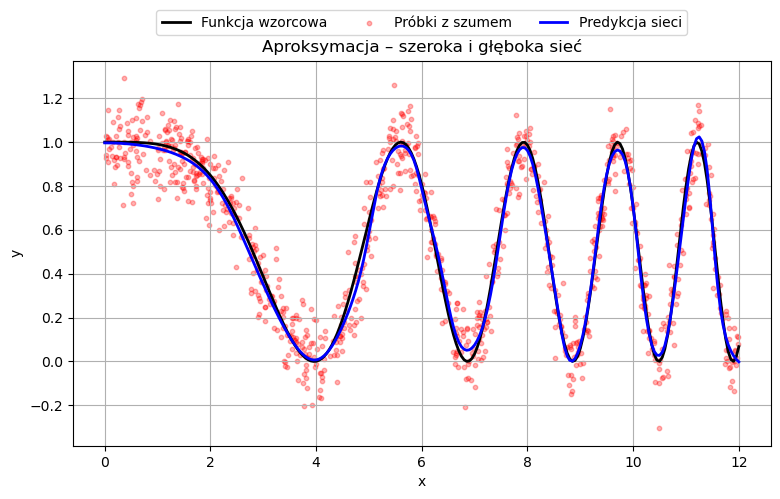

In [8]:
# Wykres aproksymacji
plt.figure(figsize=(9,5))
plt.plot(x_dense, y_dense, 'k', lw=2, label='Funkcja wzorcowa')
plt.scatter(x_data, y_data, s=10, c='r', alpha=0.3, label='Próbki z szumem')
plt.plot(x_dense, y_pred, 'b', lw=2, label='Predykcja sieci')
plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.15), ncol=3)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Aproksymacja – szeroka i głęboka sieć')
plt.grid(True); plt.show()

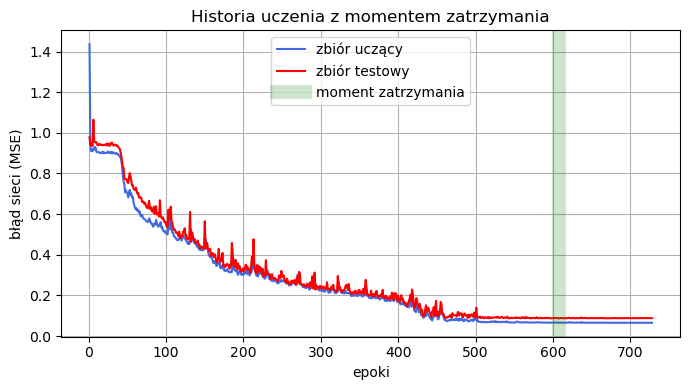

In [9]:
train = history.history['loss']
val = history.history['val_loss']
epochs = np.arange(1, len(train) + 1)

min_ep = int(np.argmin(val) + 1)
min_val = val[min_ep - 1]

plt.figure(figsize=(7, 4))
plt.plot(epochs, train, label='zbiór uczący', color='royalblue')
plt.plot(epochs, val, label='zbiór testowy', color='red')
plt.axvline(x=min_ep, color='green', alpha=0.2, lw=10, label='moment zatrzymania')

plt.xlabel('epoki')
plt.ylabel('błąd sieci (MSE)')
plt.title('Historia uczenia z momentem zatrzymania')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Podsumowanie i wnioski

- Za mało neuronów, jedna warstwa
  
    Gdy dałam jedną warstwę z kilkoma neuronami, sieć prawie wcale nie trafiała w kształt funkcji. Na wykresie linia predykcji biegła gdzieś obok – klasyczne niedouczenie.

- Stopniowe zwiększanie liczby neuronów

    Im więcej neuronów dorzucałam, tym dokładniej predykcja przyklejała się do funkcji wzorcowej. Python (a właściwie TensorFlow na CPU) mielił to dość wolno, więc sensowny efekt pojawił się dopiero przy naprawdę sporej liczbie neuronów – setki, a nawet tysiące wag.

- Dodanie kolejnych warstw

  Druga czy trzecia warstwa wyraźnie pomagała: sieć szybciej „łapała” krzywiznę funkcji i końcowy błąd był mniejszy. Jedyny minus to dłuższe czekanie na koniec treningu.

- Za duża sieć (overfitting)

  Kiedy przesadziłam z rozmiarem model zaczął uczyć się także szumu zamiast samej reguły – overfitting, którego chcemy uniknąć.

1. Więcej danych w zbiorze uczącym

Sieć ma więcej przykładów, więc łatwiej ogarnia wzorce i rzadziej przeucza się na walidacji. Minusem jest mniej próbek do rzetelnej kontroli jakości – walidacja bywa „szarpana”.

2. Mniej danych w zbiorze uczącym

Trening staje się chwiejny: sieć może przeuczyć się szybciej, bo ma mniej danych do trenowania, a walidacja jest już dość duża, więc rygorystycznie punktuje każdy błąd – często kończy się wyższym MSE.